In [10]:

import numpy as np
import pylab as pl
import networkx as nx

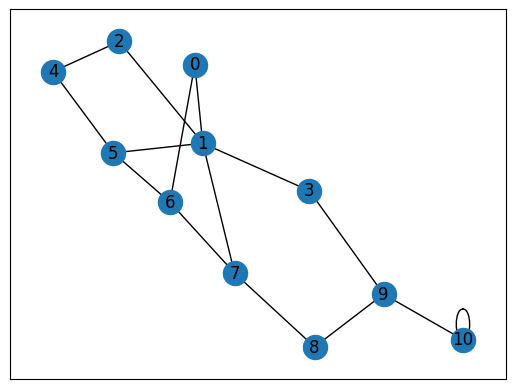

In [11]:
# Define the state space:
edges : list = [
         (0, 1), (1, 5), (5, 6), (5, 4), (1, 2), 
         (1, 3), (9, 10), (2, 4), (0, 6), (6, 7),
         (8, 9), (7, 8), (1, 7), (3, 9), (10,10)
        ]
  
goal = 10
G = nx.Graph()
G.add_edges_from(edges)
pos = nx.spring_layout(G)
nx.draw_networkx_nodes(G, pos)
nx.draw_networkx_edges(G, pos)
nx.draw_networkx_labels(G, pos)
pl.show()


In [12]:
# State space
state_space = set()
for i in range(0,len(edges)):
    state_space.update(edges[i])
state_space


{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10}

In [13]:
# M is the matrix representation of the 'allowed' paths
# This will define your 'action space' depending on the current state
MATRIX_SIZE = len(state_space)
M = np.matrix(np.ones(shape =(MATRIX_SIZE, MATRIX_SIZE)))

# -1 means that this is NOT an allowed path, and we will not provide this as an available action
M *= -1

# for each link, either set it to '0' as allowed path, or 100 if it go to the goal
SOURCE = 0
DESTINATION = 1
for point in edges:    
    # Forward direction:
    if point[DESTINATION] == goal:
        M[point] = 100
    else:
        M[point] = 0
  
    # Reverse direction:
    if point[SOURCE] == goal:        
        M[point[::-1]] = 100  # Just reverse the point order, list it backwards
    else:
        M[point[::-1]] = 0
  
  
# 'goal' is the destination node, there is no edge defined, basically this is a loop back on the destination node
# i.e. go from goal to goal, I think I could just add an end for this???
#M[goal, goal]= 100  ---> replaced it with an edge!!!
print("Action space for each state")
print(M)

Action space for each state
[[ -1.   0.  -1.  -1.  -1.  -1.   0.  -1.  -1.  -1.  -1.]
 [  0.  -1.   0.   0.  -1.   0.  -1.   0.  -1.  -1.  -1.]
 [ -1.   0.  -1.  -1.   0.  -1.  -1.  -1.  -1.  -1.  -1.]
 [ -1.   0.  -1.  -1.  -1.  -1.  -1.  -1.  -1.   0.  -1.]
 [ -1.  -1.   0.  -1.  -1.   0.  -1.  -1.  -1.  -1.  -1.]
 [ -1.   0.  -1.  -1.   0.  -1.   0.  -1.  -1.  -1.  -1.]
 [  0.  -1.  -1.  -1.  -1.   0.  -1.   0.  -1.  -1.  -1.]
 [ -1.   0.  -1.  -1.  -1.  -1.   0.  -1.   0.  -1.  -1.]
 [ -1.  -1.  -1.  -1.  -1.  -1.  -1.   0.  -1.   0.  -1.]
 [ -1.  -1.  -1.   0.  -1.  -1.  -1.  -1.   0.  -1. 100.]
 [ -1.  -1.  -1.  -1.  -1.  -1.  -1.  -1.  -1.   0. 100.]]


In [14]:
# Get the action space for current state
def get_action_space(current_state : np.array) -> np.array:
    current_state_action_list = M[current_state, ]
    allowed_actions = np.where(current_state_action_list >= 0)[1]
    return allowed_actions
 
# Chooses one of the available actions at random
def get_next_action(available_actions_range : np.array) -> int:
    next_action = int(np.random.choice(available_actions_range, 1))
    return next_action


# Update the Q matrix and return the score
# aka Q-table
# The Q-matrix is a table that has one row for each state and one column for each possible action. Each entry in the table 
# represents the expected future reward that an agent can achieve by taking a particular action in a given state. 

def update(Q:np.matrix, current_state:int, action:int, gamma:float)->float:  
  
  # 'action' is effectively the next state, so Q[action, ] get the current scores for this next state
  # here we get the best next action that has being learned, could be tied occurance, so max_index can have multiple values  
  # this is GREEDY algorthim: (i.e. no exploration)
  max_indexes = np.where(Q[action, ] == np.max(Q[action, ]))[1]
  
  if max_indexes.shape[0] > 1:  # if there are multiple best next actions, choose one randomly
      max_index = int(np.random.choice(max_indexes, size = 1))
  else: # otherwise just choose the only index available:
      max_index = int(max_indexes)

  # 
  max_value = Q[action, max_index]

  Q[current_state, action] = M[current_state, action] + gamma * max_value
  
  # Return the 'avg score' or reward obtained so far in the Q matrix
  if (np.max(Q) > 0):
    return np.sum(Q / np.max(Q)*100)
  else:
    return 0
  

In [15]:
# Q Matrix
# this contains the learned path, Q-values, represents the 'cummulative reward' an agent will rec in each state
# # the Q-value represents how 'good' the action in a particular state is
# The Bellman equation provides a recursive relationship between the value of a state and the values of its neighboring states. 
# It is a fundamental concept in reinforcement learning and is used to update the Q-values in Q-learning.
# The proof that the Bellman equation will converge to the optimal Q-values is based on the following assumptions:
# The environment is stationary, meaning that the transition probabilities and rewards are constant over time.
# The agent explores all state-action pairs infinitely often.
# The learning rate parameter used to update the Q-values satisfies the Robbins-Monro conditions.
# Under these assumptions, it can be shown that the Q-values converge to the true Q-values with probability 
# 1. This means that as the number of iterations approaches infinity, the Q-values obtained through Q-learning will converge to the optimal Q-values.
# The proof for this convergence is provided in many reinforcement learning textbooks, 
# including "Reinforcement Learning: An Introduction" by Sutton and Barto, and "Algorithms for Reinforcement Learning" by Csaba Szepesvári. 
# The proof involves the use of the theory of stochastic approximation, and it is quite technical. If you're interested, I recommend reading one of these textbooks for a detailed explanation of the proof.

Q = np.matrix(np.zeros([MATRIX_SIZE, MATRIX_SIZE]))  

gamma = 0.75        # learning rate
scores = []         # this contains the average reward at each training step used for 

# 1000 steps?
current_state = np.random.randint(0, Q.shape[0])            # start in a random state between 0 and 10
for i in range(1000):    
    action_space = get_action_space(current_state)              # get the allowed paths
    next_action = get_next_action(action_space)                 # Random selection
    score = update(Q, current_state, next_action, gamma)        # 
    scores.append(score)
    current_state = next_action
  
print("Trained Q matrix:")
print(Q / np.max(Q)*100)
#You can uncomment the above two lines to view the trained Q matrix


Trained Q matrix:
[[  0.          42.1752906    0.           0.           0.
    0.          31.54451084   0.           0.           0.
    0.        ]
 [ 31.54451084   0.          31.63146795  56.23372081   0.
   31.63146795   0.          42.1875       0.           0.
    0.        ]
 [  0.          42.1752906    0.           0.          23.72360097
    0.           0.           0.           0.           0.
    0.        ]
 [  0.          42.1752906    0.           0.           0.
    0.           0.           0.           0.          75.
    0.        ]
 [  0.           0.          31.63146795   0.           0.
   31.63146795   0.           0.           0.           0.
    0.        ]
 [  0.          42.1752906    0.           0.          23.72360097
    0.          31.54451084   0.           0.           0.
    0.        ]
 [ 31.63146795   0.           0.           0.           0.
   31.63146795   0.          42.17975575   0.           0.
    0.        ]
 [  0.          42.1752906  

Most efficient path:
[0, 1, 3, 9, 10]


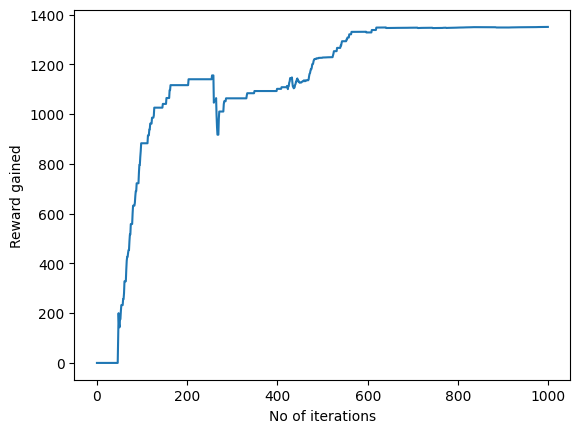

In [16]:

# Testing
current_state = 0
steps = [current_state]  # initialize at current state
  
while current_state != 10:  
    next_step_index = np.where(Q[current_state, ] == np.max(Q[current_state, ]))[1]
    if next_step_index.shape[0] > 1:
        next_step_index = int(np.random.choice(next_step_index, size = 1))
    else:
        next_step_index = int(next_step_index)
    steps.append(next_step_index)
    current_state = next_step_index
  
print("Most efficient path:")
print(steps)
  
pl.plot(scores)
pl.xlabel('No of iterations')
pl.ylabel('Reward gained')
pl.show()

Most efficient path:
[0, 1, 3, 9, 10]


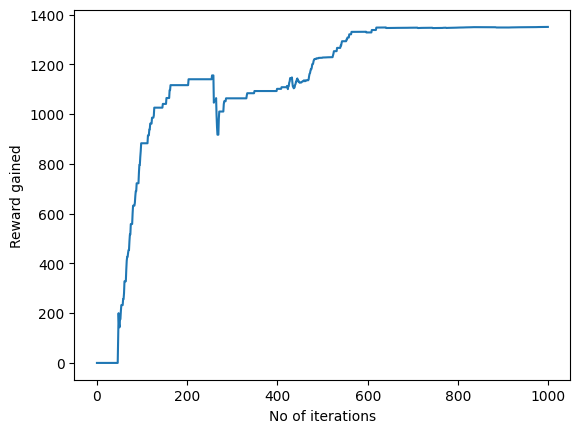

In [ ]:

# Testing
current_state = 0
steps = [current_state]  # initialize at current state
  
while current_state != 10:  
    next_step_index = np.where(Q[current_state, ] == np.max(Q[current_state, ]))[1]
    if next_step_index.shape[0] > 1:
        next_step_index = int(np.random.choice(next_step_index, size = 1))
    else:
        next_step_index = int(next_step_index)
    steps.append(next_step_index)
    current_state = next_step_index
  
print("Most efficient path:")
print(steps)
  
pl.plot(scores)
pl.xlabel('No of iterations')
pl.ylabel('Reward gained')
pl.show()

In [17]:
Q[1,]

matrix([[126.16114349,   0.        , 126.50892537, 224.90475622,
           0.        , 126.50892537,   0.        , 168.7273982 ,
           0.        ,   0.        ,   0.        ]])